**OBJECTIVE:** Illustrate how synthetic networks are generated and used in this study.

**LAST UPDATED:** 27/12/2021

**Note:** To replicate the exaggerators simulation used in our study, refer to Notebook 02

In [1]:
import numpy as np
import networkx as nx
import vimure as vm

import matplotlib.pyplot as plt
import scipy.special as sps  

from plotnine import * 

In [2]:
import inspect


def print_list_parameters(synthetic_class):
    signature = inspect.signature(synthetic_class.__init__)
    for name, parameter in signature.parameters.items():
        if name != "self" and name != "kwargs":
            default_value = None if parameter.default == inspect._empty else parameter.default
            parameter_type = None if parameter.annotation == inspect._empty else parameter.annotation
            
            msg = f"Parameter: {name:<12} | Type: {str(parameter_type):<15} | Default value: {default_value}"
            print(msg)

# Synthetic Network Models & Parameters

Currently, there are three synthetic network models implemented in our package:

- [StandardSBM](https://github.com/latentnetworks/vimure/blob/main/src/python/vimure/synthetic.py#L284)
- [DegreeCorrectedSBM](https://github.com/latentnetworks/vimure/blob/main/src/python/vimure/synthetic.py#L604)
- [Multitensor](https://github.com/latentnetworks/vimure/blob/main/src/python/vimure/synthetic.py#L639)

All of them contain the base parameters listed below:

In [3]:
print_list_parameters(vm.synthetic.BaseSyntheticNetwork)

Parameter: N            | Type: <class 'int'>   | Default value: 100
Parameter: M            | Type: <class 'int'>   | Default value: 100
Parameter: L            | Type: <class 'int'>   | Default value: 1
Parameter: K            | Type: <class 'int'>   | Default value: 2
Parameter: seed         | Type: <class 'int'>   | Default value: 10


- **N**: Number of nodes
- **M**: Number of reporters
- **L**: Number of layers (it has only been tested for L=1)
- **K**: Maximum edge weight in the adjacency matrix. When K=2 (default), the adjacency matrix will contain some Y(ij)=0 and Y(ij)=1.
- **seed**: Pseudorandom generator seed to use

## Standard SBM

The list below contains the parameters for the Standard SBM model -- which are also used by DegreeCorrectedSBM and Multitensor:

In [4]:
print_list_parameters(vm.synthetic.StandardSBM)

Parameter: C            | Type: <class 'int'>   | Default value: 2
Parameter: structure    | Type: <class 'str'>   | Default value: None
Parameter: avg_degree   | Type: <class 'float'> | Default value: 2
Parameter: sparsify     | Type: <class 'bool'>  | Default value: True
Parameter: overlapping  | Type: <class 'float'> | Default value: 0.0


**Note:** The `avg_degree` is a _desired_ average degree for the network, it is not guaranteed that the ultimate network will have that exact average degree value. Try tweaking this parameter if you want to increase or decrease the density of the network.

## Degree Corrected SBM

In addition to the parameters listed above, the Degree-Corrected SBM model also contains the following parameters:

In [5]:
print_list_parameters(vm.synthetic.DegreeCorrectedSBM)

Parameter: exp_in       | Type: <class 'float'> | Default value: 2
Parameter: exp_out      | Type: <class 'float'> | Default value: 2.5


## Generative Model with Reciprocity (CRep)

For more information about this model, see:

> Safdari, H., Contisciani, M., & De Bacco, C. (2021). _Generative model for reciprocity and community detection in networks_. Physical Review Research, 3(2), 023209.
[DOI:10.1103/PhysRevResearch.3.023209](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.023209).

In addition to the parameters listed for `BaseSyntheticNetwork` and `StandardSBM`, the GM Reciprocity model also contains the following parameters:

In [6]:
print_list_parameters(vm.synthetic.Multitensor)

Parameter: eta          | Type: None            | Default value: 0.5
Parameter: ExpM         | Type: None            | Default value: None


# Generating Ground Truth Networks - `Y`

Simply create an object with the desired synthetic network class:

In [7]:
#random_net = vm.synthetic.DegreeCorrectedSBM(L=1, C=2, avg_degree=4, sparsify=False)
random_net = vm.synthetic.Multitensor(N=100, M=100, L=1,  C=2 ,avg_degree=10, sparsify=True, eta=0.99, seed=10)

random_net

Multitensor (N=100, M=100, L=1, C=2, structure=['assortative'], avg_degree=10, sparsify=True, overlapping=False, , eta=0.99, ExpM=500)

This will produce a network object that contains a `Y` tensor that represents the ground truth network (see [scikit-tensor-py3](https://github.com/evertrol/scikit-tensor-py3)). Y can be converted to a numpy array:

In [8]:
random_net.Y.toarray()

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [9]:
random_net.Y.toarray().shape # dim: L x N x N

(1, 100, 100)

You can visualize the structure of this network with the utility function below:

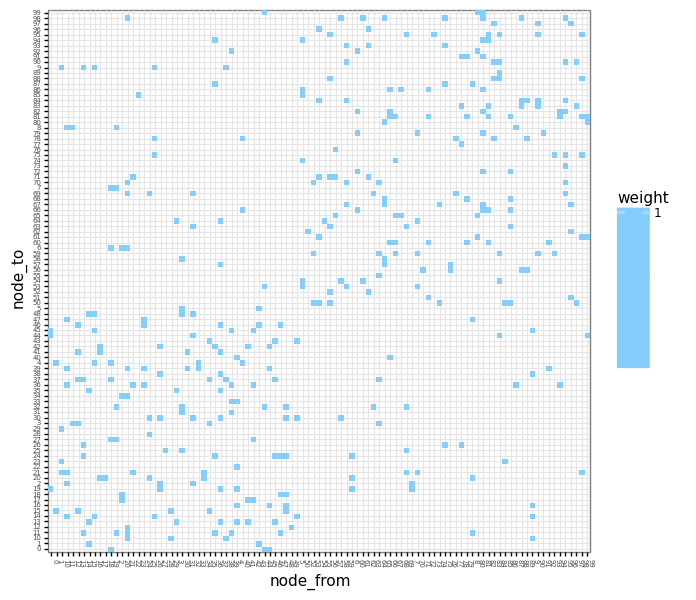

<ggplot: (8789912452825)>

In [10]:
g, node_order = vm.plot.plot_adjacency_matrix(random_net.Y.toarray()[0], return_node_order=True)

# Let us keep node_order for future visualisations in this notebook

g

Calculate some network statistics from the adjacency matrix:

In [11]:
Ys = random_net.Y.toarray()

for l in range(random_net.L):
    G = nx.from_numpy_array(Ys[l], create_using=nx.DiGraph)
    reciprocity_y = nx.overall_reciprocity(G)
    print(f"Layer: {l} | Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()} | Avg. degree: {np.mean(G.degree())/2:.3} | Reciprocity: {reciprocity_y:.3}")

Layer: 0 | Nodes: 100 | Edges: 386 | Avg. degree: 14.3 | Reciprocity: 0.788


# Generating Observed Networks - X

Given a network `Y`, we can generate N observed adjacency matrices as would have been reported by reporting nodes $m$ ($m \in N$). 

This is achieved by the function `build_X` present in the synthetic network objects. Example:

```python
random_net.build_X()

random_net.X # Now, object random_net has the X attribute - the networks as reported by nodes 
random_net.R # Now, object random_net has the R attribute - a reporter's mask (TRUE/FALSE) indicating whether a node CAN report on a tie
```

## Parameter of function `build_X`

- **flag_self_reporter**: bool = True -- indicates whether a node can only report about their own ties
- **Q**: int = None -- Maximum value of X entries. If None, it will use the network's K parameter 
- **cutoff_X**: bool = False -- whether to set X as a binary
- **lambda_diff**: float = None -- The difference betweeen each subsequent K
- **seed**: int = None,
- **verbose**: bool = True


- **mutuality**: float = 0.5 -- The mutuality parameter (from 0 to 1)
- **sh_theta**: float = 2.0 -- Shape of gamma distribution from which to draw theta. See section below
- **sc_theta**: float = 0.5 -- Scale of gamma distribution from which to draw theta. See section below
- **theta**: np.ndarray or list = None -- Custom values of theta, if provided sh_theta and sc_theta will be ignored. See section below

## 'Reliability' parameter $\theta$ - drawn from a gamma distribution

Remember: nodes are not reliable and will report imperfect views of the ground truth network. 

The 'reliability' of nodes is represented by the parameter $\theta_{lm}$ and by default are modelled as a gamma function with shape `sh_theta` and scale `sc_theta`:

$$
\theta_{lm} \sim \Gamma(sh\_theta, sc\_theta)
$$

The function `build_X` uses `sh_theta = 2.0` and `sc_theta = 0.5` by default.

```python
random_net.build_X(sh_theta=2.0, sc_theta=0.5) # Default values
```

The distribution looks as follow:

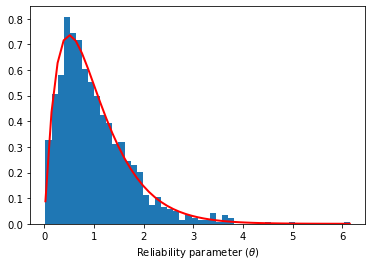

In [12]:
sh_theta, sc_theta = 2., 0.5
s = np.random.default_rng().gamma(sh_theta, sc_theta, 1000)

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(sh_theta-1)*(np.exp(-bins/sc_theta) /  (sps.gamma(sh_theta)*sc_theta**sh_theta))
plt.plot(bins, y, linewidth=2, color='r')  
plt.xlabel(r"Reliability parameter ($\theta$)")
plt.show()

**Note:** This setup aims to represent 'reliable' reporters as having $\theta = 1.0$. Reporters with very low $\theta$ ($\theta \to 0$) will tend to under-report while those with high $\theta$ (unbounded) will over-report their social ties.

In [13]:
random_net.build_X(flag_self_reporter=True, cutoff_X=False, seed=10)
X = random_net.X.toarray()

Reporter ID=30 | theta= 3.531862344075799


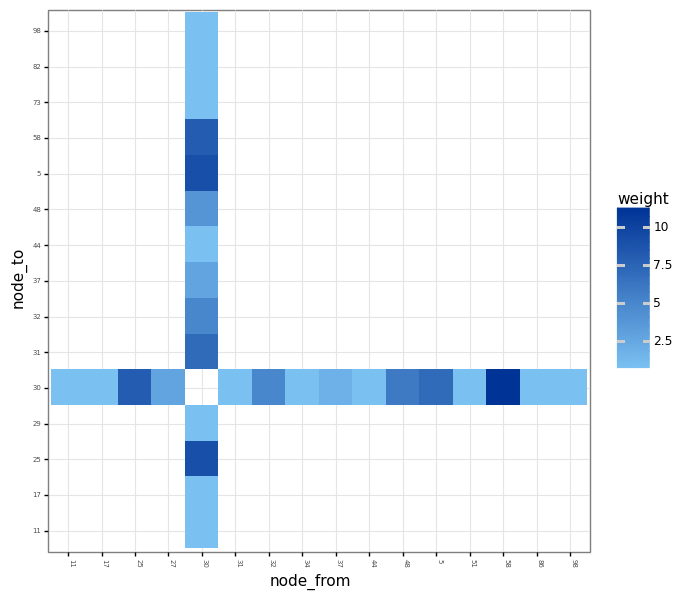

<ggplot: (8789909954789)>

In [14]:
layer = 0
reporter_id = 30 # Change this to view the network from the point of view of different reporters

print(f"Reporter ID={reporter_id} | theta= {random_net.theta[layer][reporter_id]}")
vm.plot.plot_adjacency_matrix(X[layer,:,:,reporter_id], node_order=node_order)

If we take the average of X (considering the reporter's mask), it will look like this:

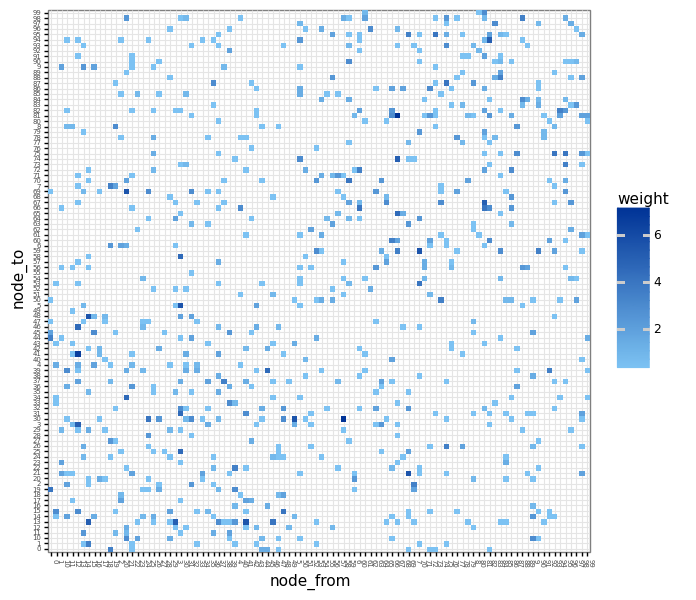

<ggplot: (8789909828081)>

In [15]:
Xavg = vm.utils.calculate_average_over_reporter_mask(random_net.X, random_net.R)

g = vm.plot.plot_adjacency_matrix(Xavg[0], node_order=node_order)

g

## 'Reliability' parameter $\theta$ - custom

Instead of drawing $\theta$ from a Gamma distribution, one could just simply pass a list of reliability parameters per each node.

We do this in our simulation of exaggerators (under-reporters and over-reporters) - see Notebook 02 for a full example.


In [16]:
theta_ratio = 0.20 # percentage of reporters that are exaggerators
exaggeration_type = "over" # exaggerators are over-reporters

custom_theta = vm.synthetic.build_custom_theta(
    gt_network=random_net,
    theta_ratio=theta_ratio,
    exaggeration_type=exaggeration_type,
    seed = 1
)

custom_theta

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 50.,  1.,  1.,
         1.,  1.,  1.,  1., 50.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., 50., 50., 50.,  1.,  1., 50.,  1.,  1.,
        50.,  1.,  1.,  1.,  1., 50.,  1.,  1.,  1.,  1.,  1.,  1., 50.,
        50.,  1.,  1.,  1., 50.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        50.,  1.,  1.,  1., 50.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        50.,  1., 50., 50., 50.,  1., 50.,  1.,  1.,  1.,  1.,  1.,  1.,
         1., 50., 50.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [17]:
custom_theta.shape # dim L x N

(1, 100)

If using a custom theta, pass it to function build_X:

2021-12-27 12:12:25,813 - [PID  724] - vm.synthetic.generate_X   - DEBUG - Ignoring sh_theta and sc_theta since a full theta matrix was informed
2021-12-27 12:12:25,813 - [PID  724] - vm.synthetic.generate_X   - DEBUG - Ignoring sh_theta and sc_theta since a full theta matrix was informed


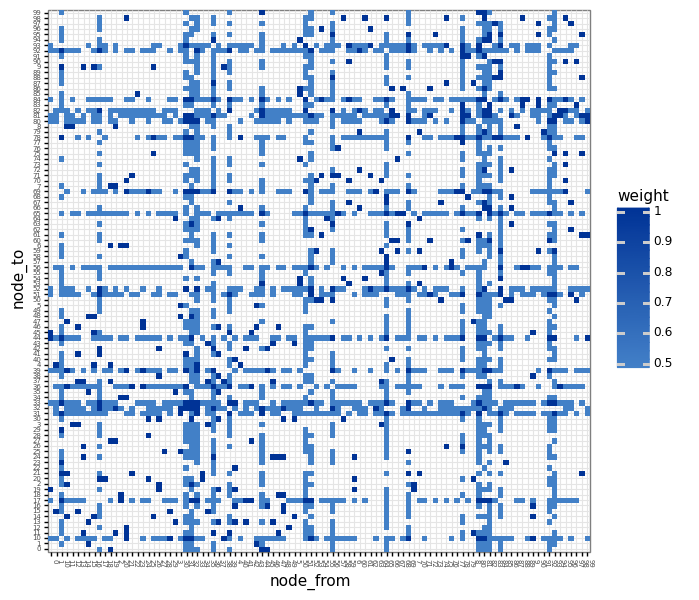

<ggplot: (8789909954865)>

In [18]:
random_net.build_X(flag_self_reporter=True, seed=10, theta=custom_theta, cutoff_X=True)
Xavg = vm.utils.calculate_average_over_reporter_mask(random_net.X, random_net.R)

g = vm.plot.plot_adjacency_matrix(Xavg[0], node_order=node_order)

g

## Mutuality Parameter $\eta$

In our model, we simulate double-sampled reports. The same reporter $m$ responds about giving and receiving social support about two nodes $i$ and $j$. Therefore, every tie type is sampled twice for each reporter, one for each direction of the interaction: $i \to j$ and $j \to i$.

The mutuality parameter ($\eta$) models people’s propensity of naming of the same individuals across both prompts.

**An example of impossibly High Mutuality on X**

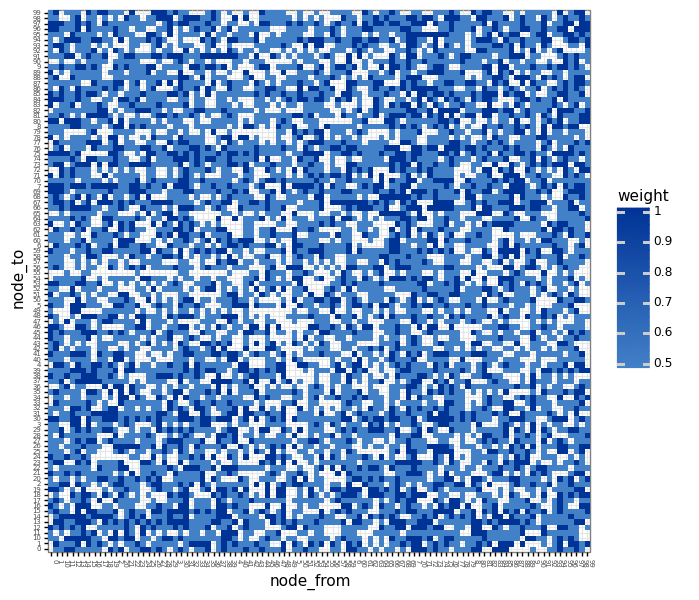

<ggplot: (8789907527644)>

In [19]:
random_net.build_X(cutoff_X=True, mutuality=0.99, flag_self_reporter=True, seed=10)
Xavg = vm.utils.calculate_average_over_reporter_mask(random_net.X, random_net.R)

g = vm.plot.plot_adjacency_matrix(Xavg[0], node_order=node_order)

g

**An example of high mutuality on X ($\eta = 0.4$)**

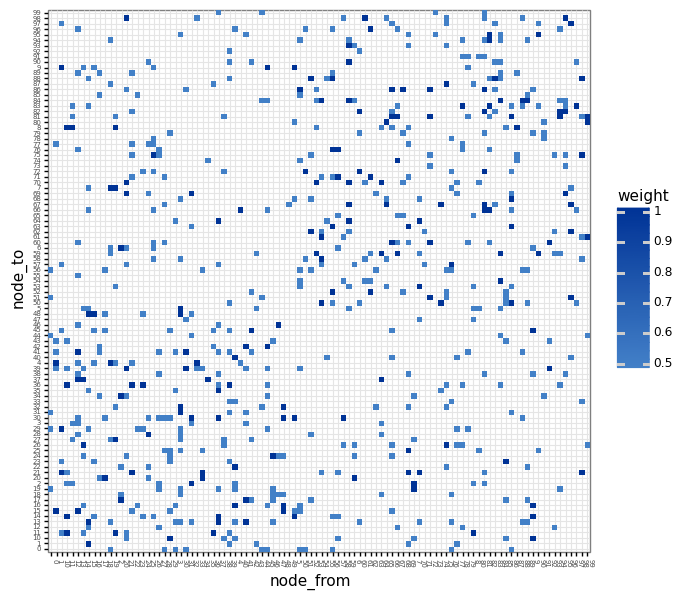

<ggplot: (8789907513332)>

In [20]:
random_net.build_X(cutoff_X=True, mutuality=0.4, flag_self_reporter=True, seed=10)
Xavg = vm.utils.calculate_average_over_reporter_mask(random_net.X, random_net.R)

g = vm.plot.plot_adjacency_matrix(Xavg[0], node_order=node_order)

g

**An example of NO mutuality on X ($\eta = 0.0$)**

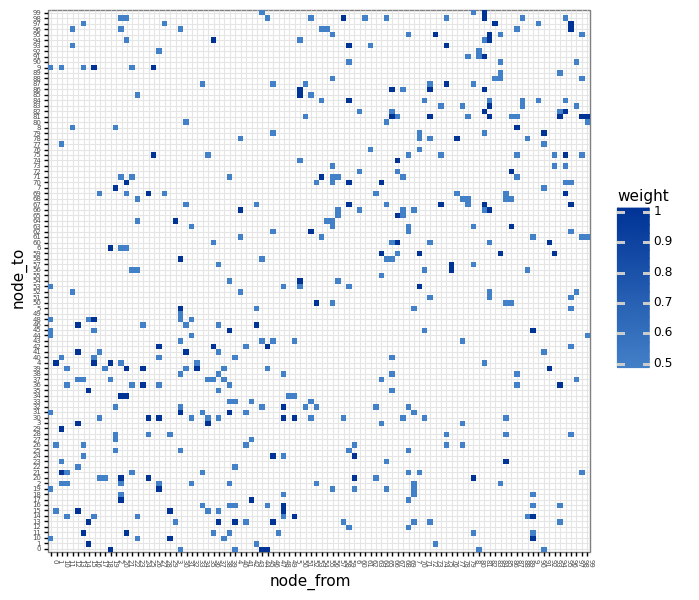

<ggplot: (8789912461020)>

In [21]:
random_net.build_X(cutoff_X=True, mutuality=0, flag_self_reporter=True, seed=10)
Xavg = vm.utils.calculate_average_over_reporter_mask(random_net.X, random_net.R)

g = vm.plot.plot_adjacency_matrix(Xavg[0], node_order=node_order)

g

**Remember:** These X adjacency matrices have all been generated for the exact same ground truth Y. One could play around with the parameters a bit further to investigate or imagine different scenarios of reporting inaccuracy.